In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval/sample_submission.csv
/kaggle/input/loan-approval/Loan Approval.ipynb
/kaggle/input/loan-approval/normalize.png
/kaggle/input/loan-approval/uni_bi_analysis.png
/kaggle/input/loan-approval/datatypes.png
/kaggle/input/loan-approval/train.csv
/kaggle/input/loan-approval/test.csv


# Import Libraries.

In [2]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Processing.

In [3]:
train_data = pd.read_csv('/kaggle/input/loan-approval/train.csv')
test_data = pd.read_csv('/kaggle/input/loan-approval/test.csv')

In [4]:
train_data.shape, test_data.shape

((614, 13), (367, 12))

In [5]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
train_data.shape, test_data.shape

((614, 13), (367, 12))

In [7]:
Loan_ID_train = train_data['Loan_ID']
Loan_ID_test = test_data['Loan_ID']
train_data = train_data.drop(['Loan_ID'], axis=1)
test_data = test_data.drop('Loan_ID', axis=1)

In [8]:
# Concat train and test data.
X = pd.concat([train_data.iloc[:, 0:-1], test_data], axis = 0)
y = train_data.iloc[:, -1]

In [9]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [10]:
X.shape

(981, 11)

In [11]:
y.head

<bound method NDFrame.head of 0      Y
1      N
2      Y
3      Y
4      Y
      ..
609    Y
610    Y
611    Y
612    Y
613    N
Name: Loan_Status, Length: 614, dtype: object>

In [12]:
y.shape

(614,)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             957 non-null    object 
 1   Married            978 non-null    object 
 2   Dependents         956 non-null    object 
 3   Education          981 non-null    object 
 4   Self_Employed      926 non-null    object 
 5   ApplicantIncome    981 non-null    int64  
 6   CoapplicantIncome  981 non-null    float64
 7   LoanAmount         954 non-null    float64
 8   Loan_Amount_Term   961 non-null    float64
 9   Credit_History     902 non-null    float64
 10  Property_Area      981 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 92.0+ KB


# Data Handling

## Missing value, Number of Missing and it's percentage, Data type.

In [14]:
Col = [col for col in X.columns if X[col].isna().sum() > 0]
Missing_value = [X[col].isna().sum() for col in X.columns if X[col].isna().sum() > 0]
Percentage_missing = [round(X[col].isna().sum() / len(X[col]) * 100, 2) for col in X.columns if X[col].isna().sum() > 0]
Datatype = [X[col].dtypes for col in X.columns if X[col].isna().sum() > 0]

In [15]:
myTable = PrettyTable()
myTable.add_column("Column Name", Col)
myTable.add_column("No of missing", Missing_value)
myTable.add_column("Percentage of missing", Percentage_missing)
myTable.add_column("Data Type", Datatype)
print(myTable)

+------------------+---------------+-----------------------+-----------+
|   Column Name    | No of missing | Percentage of missing | Data Type |
+------------------+---------------+-----------------------+-----------+
|      Gender      |       24      |          2.45         |   object  |
|     Married      |       3       |          0.31         |   object  |
|    Dependents    |       25      |          2.55         |   object  |
|  Self_Employed   |       55      |          5.61         |   object  |
|    LoanAmount    |       27      |          2.75         |  float64  |
| Loan_Amount_Term |       20      |          2.04         |  float64  |
|  Credit_History  |       79      |          8.05         |  float64  |
+------------------+---------------+-----------------------+-----------+


## Correlation plot.

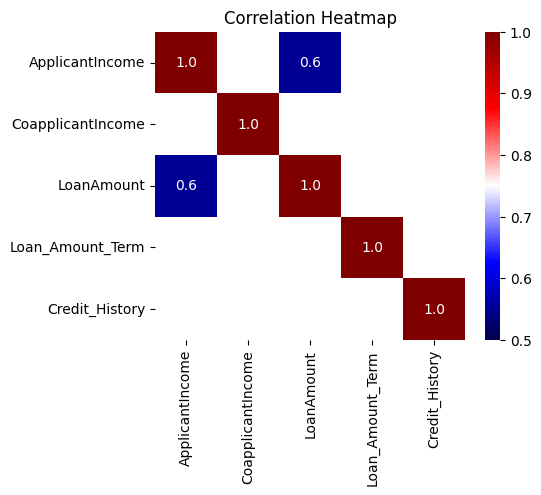

In [16]:
corr_mat = X.corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(5,4))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='seismic',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

## Handling the missing value.

### Numeric data.

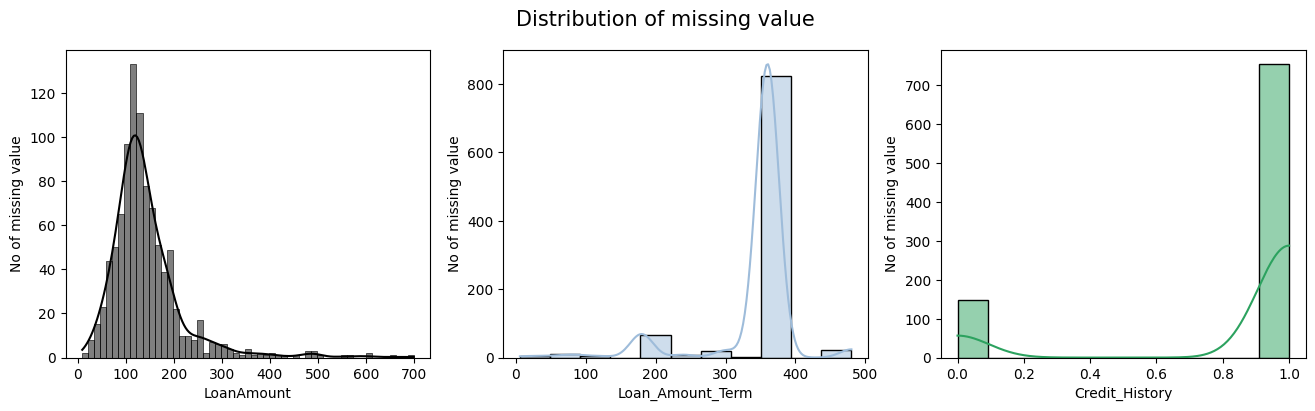

In [17]:
numeric_col = [col for col in X.columns if X[col].dtypes == 'float64' and X[col].isna().sum() > 0]
fig, axs = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
Color = ['black', '#9ebcda', '#2ca25f']

Axis = []
for j in range(1):
    for k in range(3):
        Axis.append(axs[j, k])

for i in range(len(numeric_col)):
    sns.histplot(X[numeric_col[i]], kde=True, color=Color[i], ax=Axis[i])
    Axis[i].set_ylabel('No of missing value')

for ax in axs.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)
    
fig.suptitle("Distribution of missing value", fontsize=15)
plt.show()

In [18]:
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
numeric_imputer.fit(X[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']])
X[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']] = numeric_imputer.transform(X[['LoanAmount', 'Loan_Amount_Term', 'Credit_History']])

In [19]:
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
numeric_imputer.fit(X[['Gender', 'Married', 'Dependents', 'Self_Employed']])
X[['Gender', 'Married', 'Dependents', 'Self_Employed']] = numeric_imputer.transform(X[['Gender', 'Married', 'Dependents', 'Self_Employed']])

In [20]:
X.isna().sum().sum()

0

# Relation between ApplicantIncome and LoanAmount.

## Outlier.

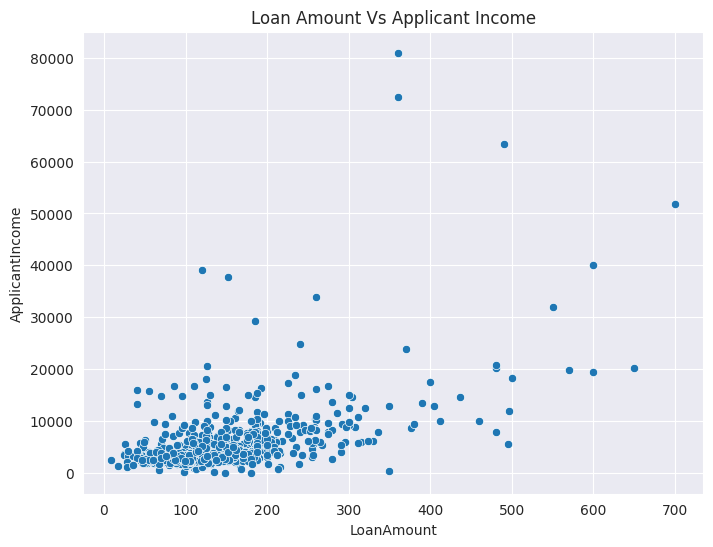

In [21]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LoanAmount', y='ApplicantIncome', data=X)
title = plt.title('Loan Amount Vs Applicant Income')

In [22]:
outlier_index = X[(X['LoanAmount'] > 520)
                           & (X['ApplicantIncome'] > 25000)].index
X.drop(outlier_index, axis=0, inplace=True)
y.drop(outlier_index, axis=0, inplace=True)

In [23]:
X.shape, y.shape

((975, 11), (611,))

# Handling catagorical variable.

In [24]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,126.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [25]:
cat_col = [{col : X[col].nunique()} for col in X.columns if X[col].dtypes == 'object']
cat_col

[{'Gender': 2},
 {'Married': 2},
 {'Dependents': 4},
 {'Education': 2},
 {'Self_Employed': 2},
 {'Property_Area': 3}]

In [26]:
X = pd.get_dummies(X, drop_first=True)

In [27]:
X.shape

(975, 14)

In [28]:
X.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849,0.0,126.0,360.0,1.0,1,0,0,0,0,0,0,0,1
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1


In [29]:
Columns = X.columns

In [30]:
X = X.iloc[:, :].values

In [31]:
scaler = StandardScaler()
scaler.fit(X[:, 0:4])
X[:, 0:4]=scaler.transform(X[:, 0:4])
X = pd.DataFrame(X, columns=Columns)

In [32]:
y = pd.get_dummies(y, drop_first=True)

In [33]:
y

,Y
0,1
1,0
2,1
3,1
4,1
...,...
609,1
610,1
611,1
612,1


In [34]:
len(y)

611

In [35]:
X1 = X.iloc[:len(y), :]
X1

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.145196,-0.590079,-0.203939,0.267619,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.092520,-0.036404,-0.176092,0.267619,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.389759,-0.590079,-1.039345,0.267619,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.468058,0.275681,-0.287480,0.267619,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.173550,-0.590079,0.004912,0.267619,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-0.408536,-0.590079,-0.969727,0.267619,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,-0.182086,-0.590079,-1.401354,-2.527380,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
608,0.562608,-0.501961,1.564336,0.267619,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
609,0.470789,-0.590079,0.645390,0.267619,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [36]:
kf = KFold(n_splits=4)
mae_train = []
mae_test = []
for train_index, test_index in kf.split(X1):
    
   X_train, X_test = X1.iloc[train_index], X1.iloc[test_index]
   y_train, y_test = y.iloc[train_index], y.iloc[test_index]
   model = LogisticRegression()
   model.fit(X_train, y_train)
   y_train_pred = model.predict(X_train)
   y_test_pred = model.predict(X_test)
   mae_train.append(mean_absolute_error(y_train, y_train_pred))
   mae_test.append(mean_absolute_error(y_test, y_test_pred))

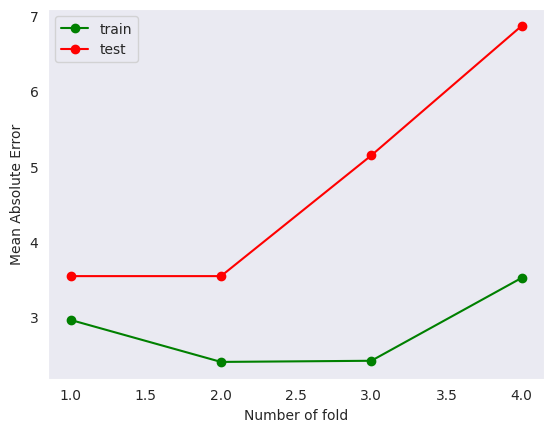

In [37]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='green', label='train')
plt.plot(folds, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.show()

In [38]:
n_folds = 5


def getRMSLE(model):
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X1, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

In [39]:
logistic = LogisticRegression()
getRMSLE(logistic)

0.43186403589389055

In [40]:
K = KNeighborsClassifier()
getRMSLE(K)

0.5192927194960463